In [7]:
# Library imports
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import expon
from scipy.stats import uniform

In [2]:
# Utility Function

def utility(ki,gammai,kj,Vj,t):
    """
    Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place

    Arguments:
        ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
        gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
        kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
        Vj: J x 1 vector of doctors' "service quality", V_j parameter.
        t: parametrized cost of visit.
    """

    # Reshaping parameters to ensure proper broadcasting
    ki = np.array(ki).reshape((1,-1))             # 1 x I
    gammai = np.array(gammai).reshape((1,-1))     # 1 x I
    kj = np.array(kj).reshape((-1,1))             # J x 1
    Vj = np.array(Vj).reshape((-1,1))             # J x 1

    return Vj * ki - t + np.where(ki >= kj, gammai, 0)
                    # This way γ_i is summed if patient i's κ_i is above doctor j's threshold κ_j.

In [3]:
# Logit Search definition

class LogitSearch:

    def __init__(self, ki,  # 1 x I vector of patients' "medical necesity", κ_i parameter.
                    gammai, # 1 x I vector of patients' "taste for certificates", γ_i parameter.
                    kj,     # J x 1 vector of doctors' chosen threshold, κ_j parameter.
                    Vj,     # J x 1 vector of doctors' "service quality", V_j parameter.
                    t,      # Scalar. Parametrized cost of visit.
                    λ):     # Scalar. Logit shape parameter.
    
        # Save parameters
        self.ki, self.gammai, self.kj, self.Vj, self.t, self.λ = ki, gammai, kj, Vj, t, λ

    def U(self):
        """
        Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place.
        See definition above.
        """

        # Unpack parameters
        ki, gammai, kj, Vj, t = self.ki, self.gammai, self.kj, self.Vj, self.t

        return utility(ki,gammai,kj,Vj,t)
    
    def alpha_matrix(self):
        """
        Intermediate matrix used to compute S matrix of patients' sij's.
        alpha_ij equals e^(λ*uij) if uij > 0, else 0 (free disposal requirement)
        """

        λ = self.λ  # scalar
        U = self.U()  # J x I matrix of uij's

        return np.where(U > 0, np.exp(λ*U), 0)
    
    def S(self):
        """
        J x I matrix 'S' of patients' strategy vectors S_i, where each component sij stands for
        the probability that patient i visits doctor j.

        (Implicit) arguments:
            ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
            gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
            kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
            Vj: J x 1 vector of doctors' "service quality", V_j parameter.
            t: Scalar. Parametrized cost of visit.
            λ: Scalar. Logit shape parameter.

        Returns:
            s_ij  =  alpha_ij / Σ_j=1^J (alpha_ij)       if      Σ_j=1^J (alpha_ij) > 0
                  =  0                                   ~
                where
            alpha_ij  =  e^(λ*uij)        if      uij > 0
                      =  0                 ~

        Output form:
            s_{i=1,j=1}   s_{i=2,j=1}   ...   s_{i=I,j=1}
            s_{i=1,j=2}   ...                   ...
            # ...                               ...
            s_{i=1,j=J}   ...           ...   s_{i=I,j=J}

        Note:
            It's set up to handle the posibility that no doctors give a certain patient i positive
            utility, in which case he visits none of them -- i.e. S_i = vector(0).
            In all other cases the probability that i visits "some" doctor equals 1.
        """

        # alpha_matrix is a J x I matrix where alpha_ij equals e^(λ*uij) if uij > 0, else 0
        alpha_matrix = self.alpha_matrix()
        # alphai_total outputs the column-wise sum of alpha_ij's, i.e. the total by patient
        alphai_total = np.sum(alpha_matrix, axis = 0)

        with np.errstate(divide='ignore', invalid='ignore'):
            # To avoid pesky division by zero warning      
            return np.where(alphai_total != 0, alpha_matrix/alphai_total, 0)

In [4]:
# Schnell Search definition

class SchnellSearch:

    def __init__(self, ki,  # 1 x I vector of patients' "medical necesity", κ_i parameter.
                    gammai, # 1 x I vector of patients' "taste for certificates", γ_i parameter.
                    kj,     # J x 1 vector of doctors' chosen threshold, κ_j parameter.
                    Vj,     # J x 1 vector of doctors' "service quality", V_j parameter.
                    t,      # Scalar. Parametrized cost of visit.
                    beta):  # Scalar. Reserve utility discount parameter.
    
        # Save parameters
        self.ki, self.gammai, self.kj, self.Vj, self.t, self.beta = ki, gammai, kj, Vj, t, beta

    def U(self):
        """
        Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place.
        See definition above.
        """

        # Unpack parameters
        ki, gammai, kj, Vj, t = self.ki, self.gammai, self.kj, self.Vj, self.t

        return utility(ki,gammai,kj,Vj,t)
    
    def U_root(self):
        """ 
        Returns the J-sized vector of patients' reserve utility (U_bar) using vectorization 
        """

        beta = self.beta
        if (beta >= 1 or beta < 0):   raise ValueError("Invalid beta. Please choose β in [0,1).")

        # We sort U column-wise, it's J x I
        U_matrix = np.sort(self.U(), axis=0)
        J = U_matrix.shape[0]
        I = U_matrix.shape[1]

        # Upper diagonal ones column
        greater_than = np.triu(np.ones((J,J)))
        # Total sum of uij for j above u_bar_i
        sum_of_uijs = greater_than @ U_matrix
        # Number of j doctors whose uij is above u_bar_i
        number_of_js = np.arange(J, 0, -1).reshape(-1,1)
        # Average expected ui when selecting u_bar_i threshold
        U_over_average = sum_of_uijs / number_of_js
        # How much that average is above the threshold
        gain_over_reserve = U_over_average - U_matrix

        # β / 1 - β
        beta_multiplier = beta / (1 - beta)
        # β / 1 - β * int_U U - U_bar dF(U)
        RHS = beta_multiplier * gain_over_reserve
        # | U_bar - β / 1 - β * int_U U - U_bar dF(U) |, which we define as error
        error = np.abs(U_matrix - RHS)
        # Row-wise take the index of the uij which minimizes error
        min_index = np.argmin(error, axis = 0)
        # Select the respecttive index for each row, outputting the argmin
        U_roots = U_matrix[min_index, np.arange(I)]

        # We select the U which minimizes error as opposed to computing the root
        # directly, which in this case doesn't matter, as we're working with
        # a discrete vector of doctors

        # Where the root is below 0, we select 0, to fulfill 'free disposal'

        # We select the U which minimizes error as opposed to computing the root
        # directly, which in this case doesn't matter, as we're working with
        # a discrete vector of doctors

        # Where the root is below 0, we select 0, to fulfill 'free disposal'
        return np.maximum(U_roots, 0)
    
    def S(self): 
        """
        J x I matrix 'S' of patients' strategy vectors S_i, where each component sij stands for
        the probability that patient i visits doctor j.

        (Implicit) arguments:
            ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
            gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
            kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
            Vj: J x 1 vector of doctors' "service quality", V_j parameter.
            t: Scalar. Parametrized cost of visit.
            λ: Scalar. Logit shape parameter.

        Returns:
            s_ij  =  1 / Σ_j=1^J I[uij > u_bar_i]       if      uij > u_bar_i 
                  =  0                                   ~
                where
            alpha_ij  =  e^(λ*uij)        if      uij > 0
                      =  0                 ~

        Output form:
            s_{i=1,j=1}   s_{i=2,j=1}   ...   s_{i=I,j=1}
            s_{i=1,j=2}   ...                   ...
            # ...                               ...
            s_{i=1,j=J}   ...           ...   s_{i=I,j=J}

        Note:
            It's set up to handle the posibility that no doctors give a certain patient i positive
            utility, in which case he visits none of them -- i.e. S_i = vector(0).
            In all other cases the probability that i visits "some" doctor equals 1.
        """

        # U matrix and U_bar vector
        U_matrix = self.U()   
        U_bars = self.U_root().reshape(1,-1)
        
        # Array which = 1 if uij > u_bar_i
        U_over_reserve = np.where(U_matrix >= U_bars, 1, 0)
        # sij is 1 divided by the total of doctors j which uij > u_bar_i, for each patient i
        sum_above = np.sum(U_over_reserve, axis = 0)
        with np.errstate(divide='ignore', invalid='ignore'):
            # To avoid pesky division by zero warning       
            return np.where(sum_above > 0,
                            np.divide(U_over_reserve, sum_above),
                            0)    

In [5]:
# Best response functions

def best_response(k0,                   # Input vector
                  custom_function,      # Function to be maximized
                  start, stop):    # Inputs for the linspace
    """
    Outputs 2 decimals best response vector within specified grid to k0 vector.

    Arguments:
        k0: Initial vector to be used for best response computation.
        custom_function: Function maximized whose argmax is the best response.
        Start, stop: Specify grid within which the maximal for custom_function is to be searched.
    """
    
    # We choose an 0.1 step size to start, to span the whole range
    linspace_values = np.arange(start, stop + 0.1, 0.1)

    k_output = []
    # Plot results for each index in i_values
    for i in range(len(k0)):
        # Store the results of the function evaluations for this component
        results_1d = []

        # Keep the original vector unchanged for components not in i_values
        k_fixed = np.copy(k0)
        
        # Evaluate the function over the linspace
        for value in linspace_values:
            k_fixed[i] = value  # Update the i-th component
            result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
            results_1d.append(result)

        max_index = np.argmax(results_1d)

        new_k = linspace_values[max_index]
        step = 0.09

        if new_k == 0:
            k_fixed[i] = new_k
            result_zero = custom_function(k_fixed)[i]
            k_fixed[i] += 0.01
            result_prime = custom_function(k_fixed)[i]

            if result_prime > result_zero:
                decimals = np.linspace(new_k, new_k + step, 10) # 10 values above inc. 0
                results_2d = []
                # Evaluate the function over the linspace
                for value in decimals:
                    k_fixed[i] = value  # Update the i-th component
                    result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                    results_2d.append(result)
                    
                max_index_2 = np.argmax(results_2d)
                result_k = decimals[max_index_2]
                k_output.append(result_k)    

            else:
                k_output.append(new_k)

        elif new_k == 1:
            k_fixed[i] = new_k
            result_one = custom_function(k_fixed)[i]
            k_fixed[i] -= 0.01
            result_prime = custom_function(k_fixed)[i]

            if result_prime > result_one:
                decimals = np.linspace(new_k - step, new_k, 10) # 10 values below inc. 1
                results_2d = []
                # Evaluate the function over the linspace
                for value in decimals:
                    k_fixed[i] = value  # Update the i-th component
                    result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                    results_2d.append(result)
                    
                max_index_2 = np.argmax(results_2d)
                result_k = decimals[max_index_2]
                k_output.append(result_k)    

            else:
                k_output.append(new_k)

        else:
            decimals = np.linspace(new_k - step, new_k + step, 19)
            # 19 because 9 decimal steps on either side plus the scalar itself

            results_2d = []
            # Evaluate the function over the linspace
            for value in decimals:
                k_fixed[i] = value  # Update the i-th component
                result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                results_2d.append(result)

            max_index_2 = np.argmax(results_2d)
            result_k = decimals[max_index_2]
            k_output.append(result_k)

    return np.array(k_output)

def best_exact(k0, n, custom_function):
    """
    Meant to be used AFTER achieving an n - 1 decimal equilibrium, it makes the equilibrium vector exact by
    one more decimal.

    Arguments:
        k0: Initial k vector, meant to be the output of an n - 1 decimals equilibrium search.
        n: Decimals of precision in k-responses.
        custom_function: Function to be maximized for best response within specified grid.
    """

    h = 1/(10**n)
    step = 9*h
    num_full = 19
    num_truncated = 10

    k_output = []
    for i in range(len(k0)):
        k_fixed = np.copy(k0)
        k_value = k0[i]

        if k_value == 0:
            k_fixed[i] = k_value
            result_zero = custom_function(k_fixed)[i]
            k_fixed[i] += h
            result_prime = custom_function(k_fixed)[i]

            if result_prime > result_zero:
                decimals = np.linspace(k_value, k_value + step, num_truncated)
                results = []
                # Evaluate the function over the linspace
                for value in decimals:
                    k_fixed[i] = value  # Update the i-th component
                    result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                    results.append(result)
                    
                max_index = np.argmax(results)
                result_k = decimals[max_index]
                k_output.append(result_k)    

            else:
                k_output.append(k_value)

        elif k_value == 1:
            k_fixed[i] = k_value
            result_one = custom_function(k_fixed)[i]
            k_fixed[i] -= h
            result_prime = custom_function(k_fixed)[i]

            if result_prime > result_one:
                decimals = np.linspace(k_value, k_value + step, num_truncated)
                results = []
                # Evaluate the function over the linspace
                for value in decimals:
                    k_fixed[i] = value  # Update the i-th component
                    result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                    results.append(result)
                    
                max_index = np.argmax(results)
                result_k = decimals[max_index]
                k_output.append(result_k)    

            else:
                k_output.append(k_value)

        else:
        
            decimals = np.linspace(k_value - step, k_value + step, num_full)

            results = []
            # Evaluate the function over the linspace
            for value in decimals:
                k_fixed[i] = value  # Update the i-th component
                result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
                results.append(result)

            max_index = np.argmax(results)
            result_k = decimals[max_index]
            k_output.append(result_k)

    return np.array(k_output)


In [6]:
# Equilibrium function

class SearchEq:
    
    def __init__(self,  I,  # Number of patients in the whole market
                        F,  # Distribution of κi
                        G,  # Distribution of γi
                        t,  # Cost of visit
                        z,  # Search function parameter
                        R,  # Revenue function Rj
                        P,  # Punishment function Pj
                        V,  # Given vector of Vj
                        sij): # Search function
       
        self.I, self.F, self.G, self.t, self.z = I, F, G, t, z      # Save parameters
        self.R, self.P, self.V, self.sij = R, P, V, sij         

    
    def S(self, k0, s=123):
        """MC simulation of the set of patient strategies out of a given set κ0 of doctor thresholds, seed s"""

        I, F, G, t, z, V, sij = self.I, self.F, self.G, self.t, self.z, self.V, self.sij    # Unpack parameters
        
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
        gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))
        
        Vj = V
        kj = k0

        return sij(ki,gammai,kj,Vj,t,z).S()

    def Q(self, k0, s=123):
        """Vector of expected patient demand by each doctor j out of an MC simulation of Si"""

        S = self.S(k0, s)

        return np.sum(S, axis = 1)
    
    def X(self, k0, s=123):
        """Vector of expected certificates granted by each doctor j out of an MC simulation of Si"""

        S = self.S(k0, s)
        F, I = self.F, self.I
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))
        # We recreate the ki vector with the same seed, so it's the same
        
        ki_greater = np.array(ki.reshape((1,-1)) >= k0.reshape((-1,1))).astype(int) 

        return np.sum(S*ki_greater, axis = 1)
    
    def utility(self, k0, s=123):

        R, P = self.R, self.P
        Q, X = self.Q(k0, s), self.X(k0, s)

        return R(Q) - P(X)

    def FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Q(k0, s)
        X = self.X(k0, s)
        dQ = self.dQ(k0)         # Jacobians of Q and J
        dX = self.dX(k0)
        dQ_gradient = np.diagonal(dQ)   # For the FOC we just use the gradient
        dX_gradient = np.diagonal(dX)

        return dR(Q)*dQ_gradient - dP(X)*dX_gradient
    
    def simple_FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Q(k0, s)
        X = self.X(k0, s)

        return (dR(Q) - dP(X))
    

    def Eq_k(self, k0, decimals, max_iter = 20, s=123):
        """Outputs the equilibrium strategies of doctors"""

        if (decimals < 2 or decimals != int(decimals)): 
            raise ValueError("Invalid n. Please choose integer >= 2.")

        x = k0 + 1
        y = k0

        start = self.F.ppf(0)
        stop = self.F.ppf(1)
        custom_function = lambda x: self.utility(x, s)

        lambda_best = lambda x: best_response(x, custom_function, start, stop)

        n = 0
        while not np.array_equal(x, y):
            n += 1
            x = y
            if n > max_iter:
                print(f"Convergence not achieved, max iterations reached: {max_iter}")
                break
            y = lambda_best(x)

        if n <= max_iter:
            print(f"Two decimal convergence achieved in {n} iterations.")
            
        if decimals == 2:
            return np.array(y)
        else:
            i = 2

            while i <= decimals:
                i += 1
                lambda_best_exact = lambda x: best_exact(x, i, custom_function)
                x = y + 1
                t = 0
                while not np.array_equal(x,y):
                    t += 1
                    x = y
                    if(t > max_iter):
                        print("Convergence not acheived, max iterations")
                        break
                    y = lambda_best_exact(x)

        return np.array(y)

                

In [57]:
# PARAMETERS

I = 10000
J = 50

b = 5
F = uniform(scale = 1)
G = uniform(scale = 1)
H = uniform(scale = 10)

f = lambda x: F.pdf(x)
g = lambda x: G.pdf(x)

rng = np.random.RandomState(seed=123)         # Set up number generator using seed
V = H.rvs(size=J, random_state=rng)     # Create J-size vector of Vj values using H
V = np.sort(V)

r = 1.5
p = 1/100

R = lambda x: r * x
P = lambda x: p/2 * x**2

dR = lambda x: r + x - x
dP = lambda x: p * x

df = lambda x: -b*f(x)

k0 = np.ones(J)*0.5

λ = 1
t = 1
beta = 0.7

In [11]:
V_example = np.linspace(0.2,10,50)

In [149]:
ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))

Vj = V
kj = k0

U_matrix = utility(ki,gammai,kj,Vj,t)
U_column = U_matrix[:,0]


In [152]:
SchnellSearch(ki,gammai,kj,Vj,t,beta).S().shape

(50, 10000)

In [49]:
LogitModel = SearchEq(I, F, G, t, λ, R, P, V, LogitSearch)
SchnellModel = SearchEq(I, F, G, t, beta, R, P, V, SchnellSearch)

np.set_printoptions(suppress=True, precision=4)

<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x1105d5260> at 0x12ae539c0>

In [50]:
SchnellModel.Eq_k(np.zeros(J), 2)

Two decimal convergence achieved in 5 iterations.


array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.1 ,
       0.11, 0.11, 0.12, 0.14, 0.27, 0.37, 0.54, 0.6 , 0.65, 0.67, 0.69,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.98])

In [158]:
LogitModel.Eq_k(np.zeros(J), 4)

Two decimal convergence achieved in 4 iterations.


array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.41, 0.41, 0.41, 0.49, 0.58,
       0.58, 0.61, 0.61, 0.64, 0.72, 0.74, 0.77, 0.77, 0.77, 0.8 , 0.81,
       0.92, 0.93, 0.95, 0.97, 0.97, 0.97])

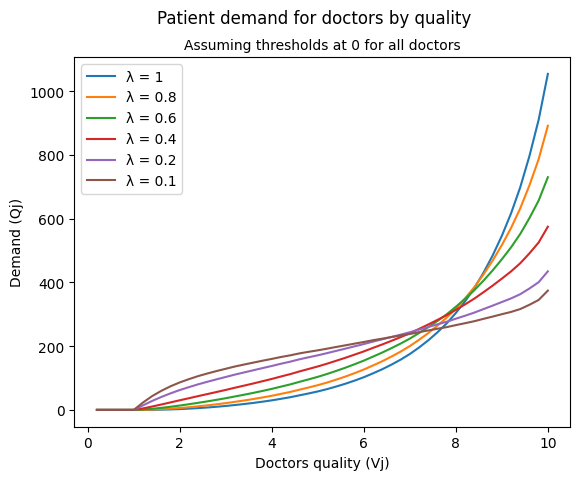

In [58]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [1, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for λ in lambda_values:
    y = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Q(k0)
    plt.plot(x, y, label=f'λ = {λ}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Assuming thresholds at 0 for all doctors', fontsize=10)
plt.show()

In [61]:

SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).X(k0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

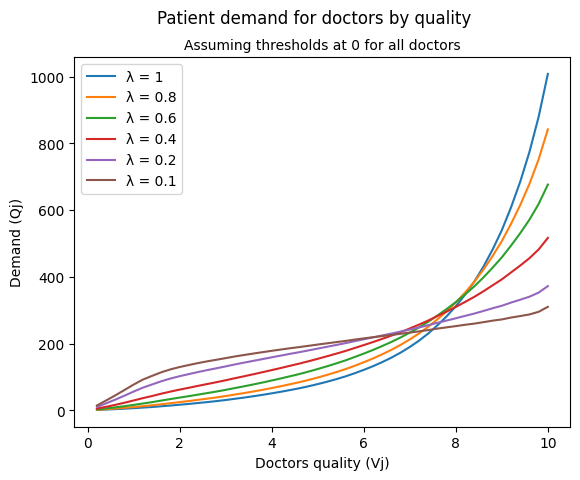

In [62]:
k0 = np.zeros(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [1, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for λ in lambda_values:
    y = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).X(k0)
    plt.plot(x, y, label=f'λ = {λ}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Assuming thresholds at 0 for all doctors', fontsize=10)
plt.show()

Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 5 iterations.


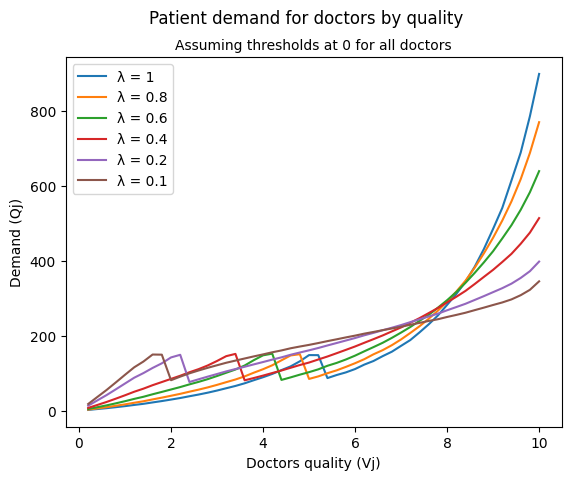

In [46]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [1, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for λ in lambda_values:
    k = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Eq_k(k0, 2)
    y = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Q(k)
    plt.plot(x, y, label=f'λ = {λ}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Taking the equilibrium vector of strategies', fontsize=10)
plt.show()

Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 5 iterations.


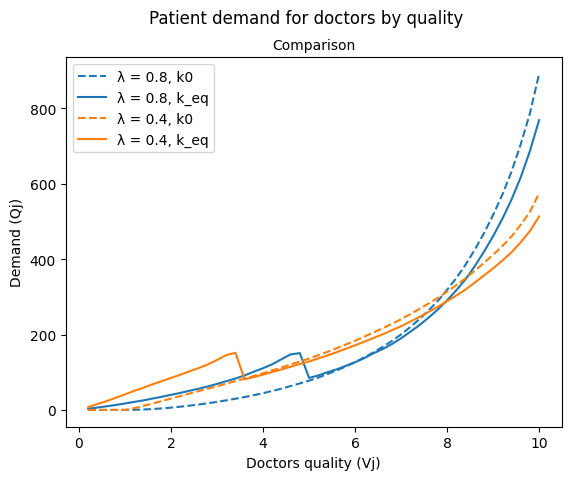

In [48]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [0.8, 0.4]
colors = ['tab:blue', 'tab:orange']

# Loop over lambda values and plot directly
x = V_example
for i, λ in enumerate(lambda_values):
    y_0 = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Q(k0)
    k = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Eq_k(k0, 2)
    y_eq = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Q(k)
    plt.plot(x, y_0, label=f'λ = {λ}, k0', linestyle = 'dashed', color=colors[i])
    plt.plot(x, y_eq, label=f'λ = {λ}, k_eq', linestyle = 'solid', color=colors[i])

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Comparison', fontsize=10)
plt.show()

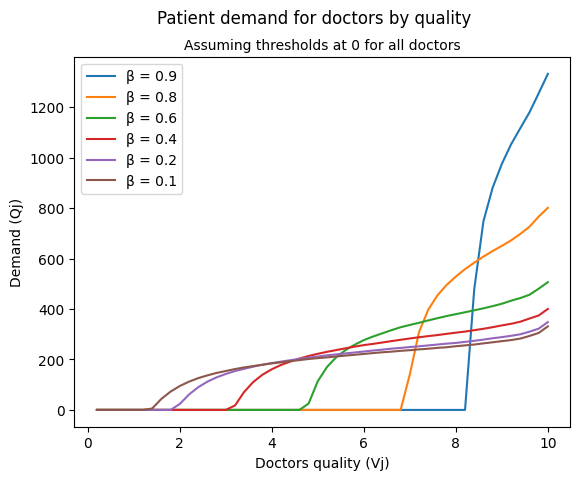

In [39]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

beta_values = [0.9, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for beta in beta_values:
    y = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k0)
    plt.plot(x, y, label=f'β = {beta}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Assuming thresholds at 0 for all doctors', fontsize=10)
plt.show()

Convergence not achieved, max iterations reached: 20
Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 4 iterations.


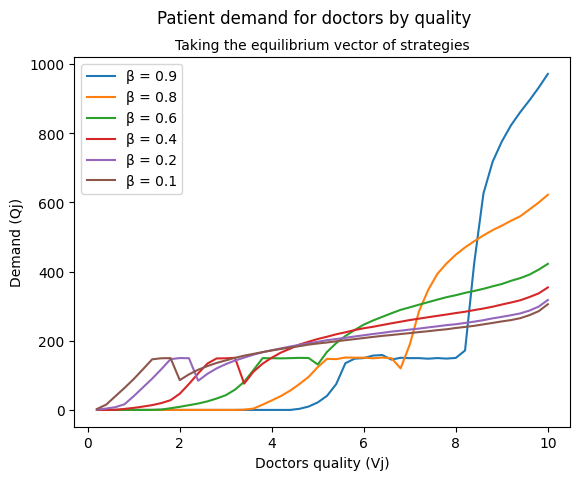

In [52]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

beta_values = [0.9, 0.8, 0.6, 0.4, 0.2, 0.1]

# Loop over lambda values and plot directly
x = V_example
for beta in beta_values:
    k = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Eq_k(k0, 2)
    y = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k)
    plt.plot(x, y, label=f'β = {beta}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Taking the equilibrium vector of strategies', fontsize=10)
plt.show()

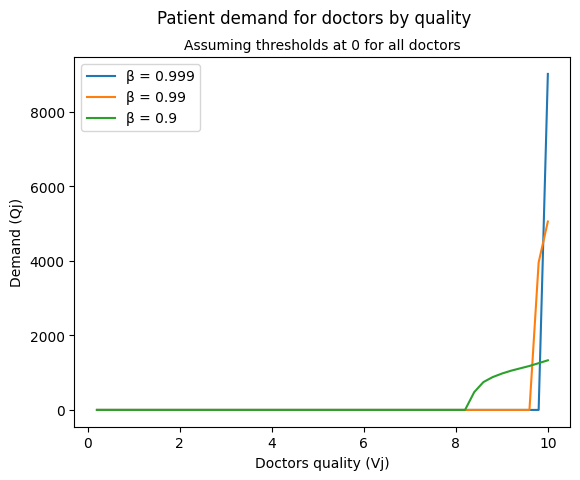

In [45]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

beta_values = [0.999, 0.99, 0.9]

# Loop over lambda values and plot directly
x = V_example
for beta in beta_values:
    y = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k0)
    plt.plot(x, y, label=f'β = {beta}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Assuming thresholds at 0 for all doctors', fontsize=10)
plt.show()

Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 4 iterations.


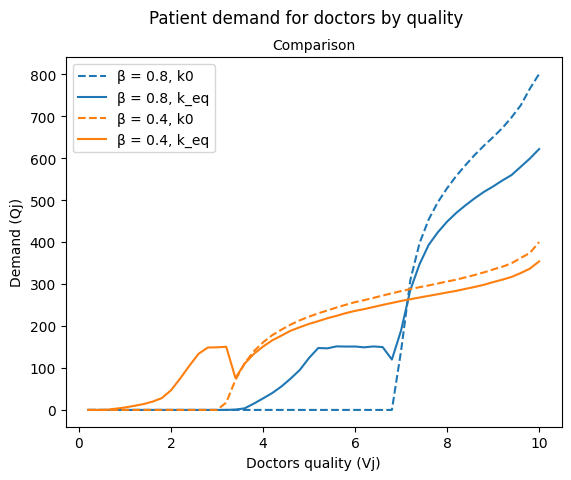

In [51]:
k0 = np.ones(J)
V_example = np.linspace(0.2,10,50)

beta_values = [0.8, 0.4]
colors = ['tab:blue', 'tab:orange']

# Loop over lambda values and plot directly
x = V_example
for i, beta in enumerate(beta_values):
    y_0 = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k0)
    k = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Eq_k(k0, 2)
    y_eq = SearchEq(I, F, G, t, beta, R, P, V_example, SchnellSearch).Q(k)
    plt.plot(x, y_0, label=f'β = {beta}, k0', linestyle = 'dashed', color=colors[i])
    plt.plot(x, y_eq, label=f'β = {beta}, k_eq', linestyle = 'solid', color=colors[i])

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('Demand (Qj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Comparison', fontsize=10)
plt.show()

Two decimal convergence achieved in 5 iterations.
Two decimal convergence achieved in 4 iterations.
Two decimal convergence achieved in 4 iterations.


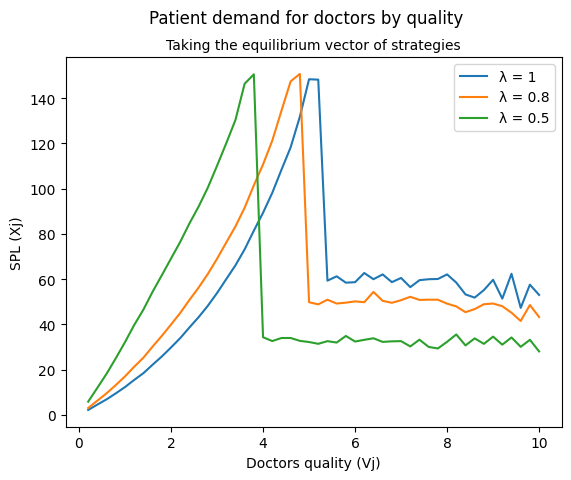

In [64]:
k0 = np.zeros(J)
V_example = np.linspace(0.2,10,50)

lambda_values = [1, 0.8, 0.5]

# Loop over lambda values and plot directly
x = V_example
for λ in lambda_values:
    k = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).Eq_k(k0, 2)
    y = SearchEq(I, F, G, t, λ, R, P, V_example, LogitSearch).X(k)
    plt.plot(x, y, label=f'λ = {λ}')

# Add legend and show plot
plt.legend()
plt.xlabel('Doctors quality (Vj)')
plt.ylabel('SPL (Xj)')
plt.suptitle('Patient demand for doctors by quality')
plt.title('Taking the equilibrium vector of strategies', fontsize=10)
plt.show()